In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import statistics as stat
import proxima_analysis as pa

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

In [7]:
experiments = [
    "NORT-Proxima_dynamicalpha", #Proxima - dynamic alpha with no retrain interval
    "NORT-Proxima_static-alpha", #Proxima - precalcualted alpha, no retrain interval
    "surrogate_only", ## Simple surrogate implementation
    "SS-UQ02-NORT_staticalpha", # Simple surrogate, uq:0.2, no retrain interval
    "DA_RT50", ## Proxima - dynamica alpha, testing single RT interval of 50 
    "DAallUQ_TEMP1000", ## Proxima - testing different retrain intervals and UQ's
    "SST1000_bestparameters", ## Simple surrogate - with different Retrain intervals tested
    "SS_RI300", ## Simple Surrogate with RI 300
    "SS-UQ02_I50", ## Simple surrogate, uq: 0.2, All temps, RI: 50
    "SS-UQall_I50", ## Simple surrogate,, all UQ, Temp: 500, RI: 50
    "dyn_nostreak", ##Proxima - dynamic alpha, no surrogate streak option
]
root_path = "../proxima_data"

In [10]:
root_path_hf = "../proxima_data"
path_str = "/".join([root_path_hf,"runtime_s1_data.csv"])
hf_times = pd.read_csv(path_str)
average_rt = hf_times['Runtime[s]'].mean()
average_rt

532.3645715755877

In [11]:
results = {n: None for n in experiments}
for name in results:
    path_str = "/".join([root_path, name, "*"])
    path = glob.glob(path_str)
    uq_thresholds, int_list, total_time, uq_time, speed_up = pa.process_times(path,hf_times)
    time_df = pa.time_to_df(uq_time)
    speedup_df = pa.speedup_to_df(speed_up)
    mae_values = pa.process_mae(path)
    mae_df = pa.mae_to_df(mae_values)
    #results[name] = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    time_mae = time_df.merge(mae_df, on=["uq", "interval","temperature"], how="inner")
    results[name]=speedup_df.merge(time_mae, on=["uq", "interval","temperature"], how="inner")

In [12]:
results["SS-UQall_I50"]

,uq,interval,temperature,speed_up,time,mae
0,0.1,50,500,0.619,855.027,0.000162
1,0.2,50,500,1.154,458.786,0.000665
2,0.3,50,500,2.314,228.795,0.001788
3,0.4,50,500,3.963,133.559,0.003104
4,0.5,50,500,5.996,88.287,0.007536
5,0.6,50,500,8.783,60.266,0.010630
6,0.7,50,500,10.715,49.402,0.014648


In [13]:
def graph_values(name):
    _t_sa = results[name]['time']
    _speedup_sa = results[name]['speed_up']
    _temp_sa = results[name]['temperature']
    _mae_sa = results[name]['mae']
   
    _temp_sa, _t_sa, _mae_sa = zip(*sorted(zip(_temp_sa, _t_sa,_mae_sa)))
    hm_mae_sa = stat.harmonic_mean(_mae_sa)
    hm_t_sa = stat.harmonic_mean(_t_sa)
    _mae_sa = _mae_sa + (hm_mae_sa,)
    _t_sa = _t_sa + (hm_t_sa,)
    _temp_sa = _temp_sa + ('HM',)
    return _mae_sa,_t_sa, _temp_sa
    
_mae_sa,_t_sa,_temp_sa = graph_values("NORT-Proxima_static-alpha")
_mae_da,_t_da,_temp_da = graph_values("NORT-Proxima_dynamicalpha")
_mae_ssnort,_t_ssnort, _temp_ssnort = graph_values("SS-UQ02-NORT_staticalpha")
_mae_ss,_t_ss,_temp_ss = graph_values("SS-UQ02_I50")
_mae_ss300,_t_ss300,_temp_ss300 = graph_values("SS_RI300")
_mae_nostreak, _t_nostreak, _temp_nostreak = graph_values("dyn_nostreak")

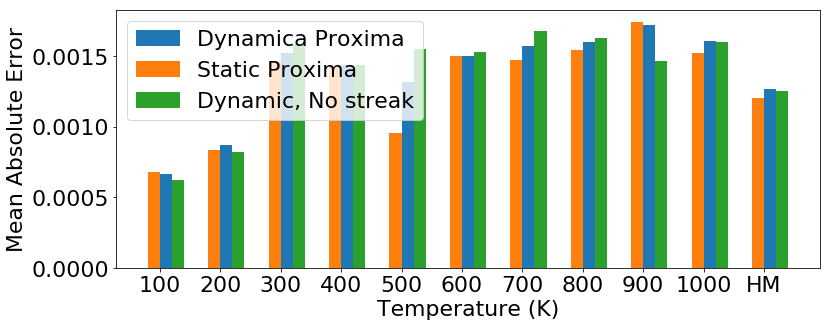

In [18]:
RI= True #set true or false depending on retrain interval usage
SS = False #Comparing with simple surrogate
labels = list(_temp_ssnort)

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars
fig, ax = plt.subplots(figsize=(12,5))

rects1 = ax.bar(x + width/2, list(_mae_da), width, label='Dynamica Proxima')
rects2 = ax.bar(x - width/2, list(_mae_sa), width, label='Static Proxima')
rects4 = ax.bar(x + (width/2)+width, list(_mae_nostreak), width, label='Dynamic, No streak')
if SS:
    if RI:
        rects3 = ax.bar(x + (width/2)+width*2, list(_mae_ss300), width, label='Simple Surrogate, RI=300')
    else:
        rects3 = ax.bar(x + (width/2)+width*2, list(_mae_ssnort), width, label='Simple Surrogate: No RI')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Absolute Error')
ax.set_xlabel("Temperature (K)")
#ax.set_title('Surrogate Method Comparison: Speed-up Across Temperatures')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.savefig('Figures/3prox_MAEbar.png')
